<a href="https://colab.research.google.com/github/RMoulla/DL_Pytorch/blob/main/TP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modèle BERT pour l'analyse de sentiments**

# Objectif du TP

L’objectif de ce TP est de réaliser un fine-tuning d’un modèle BERT pré-entraîné pour la classification de commentaires sur des critiques de films (dataset IMDB). Concrètement, nous allons ajouter une couche linéaire au modèle BERT pré-entraîné, dont nous allons ajuster les poids sur un ensemble des données IMDB.

Le TP se décline selon les étapes suivantes :

# Étapes principales du TP

1. **Charger un sous-ensemble du dataset IMDB** et séparer les données en jeu d’entraînement et jeu de test.
2. **Convertir les critiques textuelles en séquences de tokens** grâce au tokenizer de BERT.
3. **Créer une classe `IMDBDataset`** qui encapsule les textes, les labels et la logique d’encodage (tokenisation et gestion des masques).
4. **Définir un modèle `BertClassifier`** composé d’un BERT pré-entraîné (gelé dans ce code) et d’une couche linéaire assurant la classification binaire.
5. **Mettre en place la procédure d’entraînement** : pour plusieurs époques successives, parcourir les données d’entraînement par batch, calculer la perte et mettre à jour les paramètres de la couche de classification.
6. **Évaluer périodiquement les performances** sur le jeu de test (calcul de la perte moyenne et de l’accuracy).

In [1]:
!pip install --upgrade --no-cache-dir torch transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 267.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 302.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 278.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 270.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 407.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 289.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 293.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 422.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 298.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 285.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 301.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 271.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -qU transformers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.


In [3]:
!pip install fsspec==2024.6.0
!pip install datasets==2.14.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.6.0 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.7.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.0
    Uninstalling fsspec-2024.6.0:
      Successfully uninstalled f

In [4]:

import torch
print("PyTorch:", torch.__version__)
print("CUDA:", torch.version.cuda)
!nvcc --version

PyTorch: 2.7.1+cu126
CUDA: 12.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [5]:
!nvidia-smi

Thu Jul 10 07:50:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


## Préparation des données

Nous définissons ici la classe IMDBDataset, héritée de Dataset. Elle prend en entrée des listes de textes et de labels binaires, ainsi qu’un tokenizer BERT et une taille maximale de séquence. Dans le constructeur, on vérifie que tous les labels sont bien à 0 ou 1, puis on enregistre le tout comme attributs internes. La méthode `__getitem__` réalise la tokenisation de chaque texte, avec un éventuel tronquage ou du padding pour atteindre la longueur requise. Elle renvoie finalement un dictionnaire contenant les tenseurs `input_ids`, `attention_mask` et `labels`, prêts à être utilisés par un modèle BERT lors de l’entraînement ou de l’inférence.

In [6]:
from torch.utils.data import Dataset
from datasets import load_dataset

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts # les commentaires
        self.labels = labels  # labels 0 ou 1
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Vérification des labels
        unique_labels = set(self.labels)
        print(f"Labels uniques dans le dataset: {unique_labels}")
        # Comme c'est de la classification binaire, on veut {0, 1}
        assert all(lbl in [0, 1] for lbl in unique_labels), \
            f"Labels hors limite détectés: {unique_labels}"

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
print("Chargement du dataset IMDB...")
dataset = load_dataset("imdb")

Chargement du dataset IMDB...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
# Afficher la taille des splits
print(f"Taille du train : {len(dataset['train'])}")
print(f"Taille du test  : {len(dataset['test'])}")

Taille du train : 25000
Taille du test  : 25000


In [9]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [10]:
dataset['train']['label'][0]

0

In [11]:

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sample = IMDBDataset(dataset['train']['text'][:1], dataset['train']['label'][:1], tokenizer, max_len=256)[0]

print("Texte original :")
print(dataset['train']['text'][0])
print("\nTokenized input :")
print(tokenizer.tokenize(dataset['train']['text'][0]))

print("\nEncodage final (input_ids) :")
print(sample["input_ids"])  # IDs des tokens
print("\nAttention mask :")
print(sample["attention_mask"])  # 1s et 0s
print("\nLabel associé :")
print(sample["labels"])  # Label (0 ou 1)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Labels uniques dans le dataset: {0}
Texte original :
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, t

## Construction et entraînement du modèle de classification

Nous allons construire le modèle de classification de sentiments sur un sous-ensemble du dataset IMDB à l’aide d’un modèle `BertClassifier`. Il définit notamment deux fonctions d’entraînement et d’évaluation, configure les hyperparamètres, crée les jeux de données et exécute plusieurs époques d’apprentissage pour optimiser la couche de classification.

- **Définition du modèle** : La classe `BertClassifier` combine un modèle BERT pré-entraîné et une couche linéaire pour la classification.

- **Fonction d’entraînement (`train_epoch`)** : Elle parcourt les données par batch, calcule la perte (cross-entropy), met à jour la couche de classification et retourne la perte moyenne et l’accuracy.

- **Fonction d’évaluation (`eval_model`)** : Elle parcourt les données de validation ou de test, calcule la perte moyenne, l’accuracy et retourne ces métriques sans modifier le modèle.

- **Configuration des hyperparamètres** : On définit ici les hyperparamètres du modèle :batch size, taux d’apprentissage, nombre d’époques, taille maximale des séquences et  nombre de classes.

- **Chargement du dataset IMDB** : On sélectionne les échantillons d'entraînement et de test.

- **Tokenisation** : On utilise `BertTokenizer` pour transformer les critiques textuelles en séquences de tokens.

- **Création des `IMDBDataset`** : On convertit des tokens et labels en objets PyTorch (input_ids, attention_mask, labels).

- **Initialisation du modèle** : Instanciation de `BertClassifier` et association au device (CPU ou GPU).

- **Boucle d’entraînement** : Pour chaque époque, on entraîne le modèle sur les données d’entraînement puis on l’évalue sur les données de validation.

In [12]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

# Vérifier si un GPU est disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")

######## Définition du modèle ##########

class BertClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BertClassifier, self).__init__()
        # On charge BERT (base uncased)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Retour par défaut : dictionnaire (return_dict=True)
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Récupération du "pooler_output"
        pooled_output = outputs.pooler_output  # [batch_size, hidden_dim]
        output = self.drop(pooled_output)
        return self.out(output)


#### Définition de la fonction train ####


def train_epoch(model, data_loader, optimizer, device):
    # Geler les paramètres de BERT
    for param in model.bert.parameters():
        param.requires_grad = False

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

    return total_loss / len(data_loader), correct_predictions.double() / total_predictions


#### Définition de la fonction eval ####

def eval_model(model, data_loader, device):
    """
    Évalue les performances du modèle sur un jeu de validation ou de test.

    :param model: Modèle BERT ou GPT fine-tuné.
    :param data_loader: DataLoader contenant les données à évaluer.
    :param device: Appareil à utiliser (CPU ou GPU).
    :return: Moyenne de la perte et précision sur les données évaluées.
    """
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Désactiver la dérivation automatique
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Calcul des prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Calcul de la perte
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()

            # Calcul des prédictions correctes
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)

    # Moyenne des pertes et précision totale
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_predictions
    return avg_loss, accuracy


######## Entraînement du modèle #########



BATCH_SIZE = 16
EPOCHS = 2
MAX_LEN = 128
LEARNING_RATE = 2e-4
N_CLASSES = 2  # Binaire : positif (1) ou négatif (0)


# On prend seulement une partie du dataset pour ce test
# - Ex : 10000 pour l'entraînement
# - Ex : 500 pour le test
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

print(f"Taille du dataset d'entraînement : {len(train_texts)}")
print(f"Taille du dataset de test : {len(test_texts)}")

print("Distribution des labels (train):", np.bincount(train_labels))
print("Distribution des labels (test) :", np.bincount(test_labels))

print("Initialisation du tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print("Création des datasets...")
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, max_len=MAX_LEN)
val_dataset = IMDBDataset(test_texts, test_labels, tokenizer, max_len=MAX_LEN)

print("Création des dataloaders...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print("Initialisation du modèle...")
model = BertClassifier(N_CLASSES).to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
best_accuracy = 0

print("Début de l'entraînement...")
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss:.3f}, accuracy: {train_acc:.3f}')

    val_loss, val_acc = eval_model(model, val_loader, device)
    print(f'Val loss: {val_loss:.3f}, accuracy: {val_acc:.3f}')

    # Sauvegarde du meilleur modèle si l'accuracy s'améliore
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_imdb.pt')
        print(f'Nouveau meilleur modèle sauvegardé avec accuracy: {val_acc:.3f}')

    print('-' * 50)

Utilisation de : cuda
Taille du dataset d'entraînement : 25000
Taille du dataset de test : 25000
Distribution des labels (train): [12500 12500]
Distribution des labels (test) : [12500 12500]
Initialisation du tokenizer...
Création des datasets...
Labels uniques dans le dataset: {0, 1}
Labels uniques dans le dataset: {0, 1}
Création des dataloaders...
Initialisation du modèle...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Début de l'entraînement...

Epoch 1/2


Training: 100%|██████████| 1563/1563 [04:05<00:00,  6.37it/s]


Train loss: 0.658, accuracy: 0.605


Evaluating: 100%|██████████| 1563/1563 [04:07<00:00,  6.32it/s]


Val loss: 0.604, accuracy: 0.707
Nouveau meilleur modèle sauvegardé avec accuracy: 0.707
--------------------------------------------------

Epoch 2/2


Training: 100%|██████████| 1563/1563 [04:13<00:00,  6.16it/s]


Train loss: 0.614, accuracy: 0.668


Evaluating: 100%|██████████| 1563/1563 [04:10<00:00,  6.25it/s]


Val loss: 0.575, accuracy: 0.728
Nouveau meilleur modèle sauvegardé avec accuracy: 0.728
--------------------------------------------------


## Visualisation de l'architecture du modèle

In [18]:
!pip install torchinfo

In [14]:
from torchinfo import summary
fake_input_ids = torch.randint(0, 30522, (2, MAX_LEN)).to(device)
fake_attention_mask = torch.ones((2, MAX_LEN), dtype=torch.long).to(device)

In [15]:
# On crée un faux batch "représentatif" pour inspecter la structure.
fake_input_ids = torch.randint(0, 30522, (2, MAX_LEN)).to(device)
fake_attention_mask = torch.ones((2, MAX_LEN), dtype=torch.long).to(device)

summary(model, input_data=(fake_input_ids, fake_attention_mask))

Layer (type:depth-idx)                                       Output Shape              Param #
BertClassifier                                               [2, 2]                    --
├─BertModel: 1-1                                             [2, 768]                  --
│    └─BertEmbeddings: 2-1                                   [2, 128, 768]             --
│    │    └─Embedding: 3-1                                   [2, 128, 768]             (23,440,896)
│    │    └─Embedding: 3-2                                   [2, 128, 768]             (1,536)
│    │    └─Embedding: 3-3                                   [1, 128, 768]             (393,216)
│    │    └─LayerNorm: 3-4                                   [2, 128, 768]             (1,536)
│    │    └─Dropout: 3-5                                     [2, 128, 768]             --
│    └─BertEncoder: 2-2                                      [2, 128, 768]             --
│    │    └─ModuleList: 3-6                                  --     

## Visualisation des embeddings de BERT

In [16]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

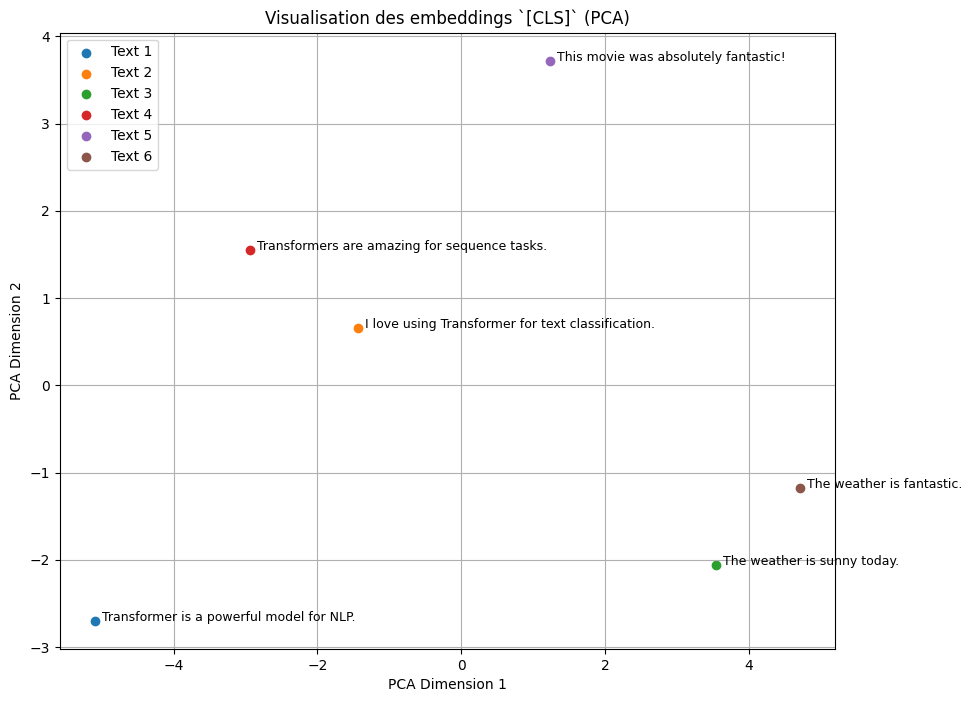

In [17]:
def visualize_cls_embeddings(model, tokenizer, texts, device):
    """
    Visualiser les embeddings `[CLS]` de plusieurs textes.

    :param model: Le modèle BERT fine-tuné
    :param tokenizer: Le tokenizer associé
    :param texts: Une liste de phrases à analyser
    :param device: CPU ou GPU
    """
    cls_embeddings = []

    # Tokenization et passage dans BERT pour chaque texte
    for text in texts:
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_tensors='pt',
            truncation=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = model.bert(**inputs)

        # Récupération de l'embedding `[CLS]`
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        cls_embedding = last_hidden_state[:, 0, :]    # Embedding `[CLS]`
        cls_embeddings.append(cls_embedding.cpu().numpy())

    # Conversion en array pour la réduction de dimensions
    cls_embeddings = np.vstack(cls_embeddings)

    # Réduction de dimension (PCA)
    pca = PCA(n_components=2)
    cls_embeddings_2d = pca.fit_transform(cls_embeddings)

    # Visualisation
    plt.figure(figsize=(10, 8))
    for i, text in enumerate(texts):
        plt.scatter(cls_embeddings_2d[i, 0], cls_embeddings_2d[i, 1], label=f"Text {i+1}")
        plt.text(cls_embeddings_2d[i, 0] + 0.1, cls_embeddings_2d[i, 1], text, fontsize=9)

    plt.title("Visualisation des embeddings `[CLS]` (PCA)")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'utilisation
texts = [
    "Transformer is a powerful model for NLP.",
    "I love using Transformer for text classification.",
    "The weather is sunny today.",
    "Transformers are amazing for sequence tasks.",
    "This movie was absolutely fantastic!",
    "The weather is fantastic."
]

visualize_cls_embeddings(model, tokenizer, texts, device)